# LSST Camera Sensor Annomalies: Figures

Author: Johnny Esteves, University Of Michigan


The figure 2 and 3 are the mean signal across the rows and columns. 

In [3]:
cd ..

/Users/jesteves/Documents/GitHub/lsst-treeRing


In [4]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [5]:
def saveFig(fig, fname, dpi=120):
    fig.savefig(fname, dpi=dpi, format='pdf', bbox_inches='tight')

## Load Data

Retrieve the output measurements from the spotgrid detector code, ```mixcoatl```.


### Mixcoatl output

<b> Updates since raft9 data </b>:

<li> correction for shaking on the z-direction of the xy-motor plataform </li>
<li> new distortion map imaging functionality </li>    
<li> compute ellipticities based on the second moments </li>
<li> transform the vectors to tree ring coordinates </li>

The respective functions are: <br>
```sensor.correct_shaking()``` <br>
```sensor.get_imaging_map()``` <br>
```sensor.compute_ellipticities()``` <br>
```sensor.transform_to_treeRing_coords()``` <br>


In [6]:
import os

tmp_file = './tmp/Figure2.pkl'
is_local_file = os.path.isfile(tmp_file)
# is_local_file = False

In [7]:
import pickle
if is_local_file:
    figure2 = pickle.load(open(tmp_file, "rb"))
    print('Local file loaded succsefuly: %s' % tmp_file)
    print('Please skip the load section')
else:
    print('Local file not found: %s' % tmp_file)
    print('Run the following 1.2 section, it might take some time')

You are not connected to a LSST machine
Fake Bluter
Local file loaded succsefuly: ./tmp/Figure2.pkl
Please skip the load section


## Scikit-Image

In [169]:
image = figure2['pos-y'][3].diff
lines = np.linspace(0,image.shape[1]+1,9)

In [170]:
vmin, vmax = np.nanpercentile(image.flatten(), [16, 84])
yline = 1500
ywidth = 500

mask = np.abs(image)> 2.*(vmax-vmin)
imagem = image.copy()
imagem[mask] = np.nan


In [171]:
np.nanstd(imagem.flatten())

0.0029540190735487274

In [172]:
def compute_intensity_profile(image, y0, yend, ywidth, x0, xend):
    from skimage.measure import profile_line
    start = (y0, x0) #Start of the profile line row=yline, col=10
    end = (yend, xend) #End of the profile line row=yend, col=last

    profile = profile_line(image, start, end, linewidth=ywidth)
    xline = np.linspace(start[1], end[1], profile.size)
    yline = np.linspace(start[0], end[0], profile.size)
    return xline, yline, profile

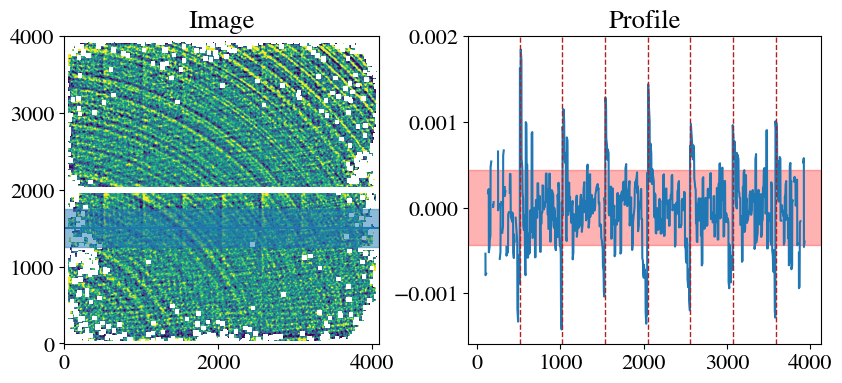

In [173]:
from skimage.measure import profile_line
from scipy.signal import savgol_filter

line, _, profile = compute_intensity_profile(imagem, yline, yline, ywidth, 10, image.shape[1]-10)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title('Image')
ax[0].imshow(imagem, vmin=vmin, vmax=vmax)
ax[0].axhline(yline, color='tab:blue')
ax[0].axhspan(yline-ywidth/2., yline+ywidth/2., color='tab:blue', alpha=0.5)

ax[1].set_title('Profile')
ax[1].plot(line, profile)
nstd = np.nanstd(profile)
ax[1].axhspan(-nstd, nstd, color='r', alpha=0.3)
# ax[1].plot(nline, noise, 'r')

for i in range(7):
    ax[1].axvline(lines[i+1],color='firebrick',lw=1, ls='--')
    
# ax[1].set_ylim(vmin, vmax)

In [378]:
def make_plot_figure2(figure, ix, yline=1500, width=500, highPassFilter=True):
    fig, axs = plt.subplots(1, 3, figsize=(14, 5))

    variables = [['flux'],
                 ['pos-x','pos-y'],
                 ['shape-x','shape-y']]
    
    for i, _variables in enumerate(variables):
        shift = 0
        for var in _variables:
            image, ring = pick_image(figure, var, ix, highPassFilter)
            imagem, vmin, vmax = mask_image(image)
            label = keys2[var][3]
            color = colorKeys[var]
            
            # do the plot
            plot_intensity_profile(imagem+shift, yline, width, ax=axs[i], label=label, color=color, lw=1)
            ylims.append([vmin, vmax])
            axs[i].axhline(shift, ls='--', color='gray')
            # update          
            #shift += vmax
            shift = axs[i].get_yticks()[-1]
                    
        # make amplifier lines
        for li in np.linspace(0,image.shape[1],9):
            axs[i].axvline(li,color='grey',ls='--',lw=1,alpha=0.4)
            
        # set ylabels
        axs[i].legend(loc=3, fontsize=12)
        axs[i].set_title(r'%s'%(keys2[var][1]))
        axs[i].set_ylabel(r'%s'%(keys2[var][2]))
    
    fig.suptitle(f'{ring.sensor.upper()} Sensor - {ring.sensorbay}')
    fig.tight_layout()

def pick_image(figure, variable, ix, highPassFilter=True):
    rings = figure[variable]
    self = rings[ix]
    if not highPassFilter:
        img = self.img.copy()
    else:
        img = self.diff.copy()        
    return img, self

def mask_image(image):
    vmin, vmax = np.nanpercentile(image.flatten(), [16, 84])
    vlow, vhig = vmin-3.*(vmax-vmin)/2., vmax+3.*(vmax-vmin)/2.
    mask = (image<vlow) | (image>vhig)
    
    imagem = image.copy()
    imagem[mask] = np.nan
    return imagem, vmin, vmax

def plot_intensity_profile(image, yline, width, ax=None, noise=False, **kwargs):
    if ax is None: ax = plt.gca()
    
    # compute profile
    x0, xend = 250, image.shape[1]-250
    line, _, profile = compute_intensity_profile(image, yline, yline, x0, xend, width)

    # get noise level
    nstd, nm = np.nanstd(profile), np.nanmedian(profile)
    if noise:
        ax.axhspan(nm-nstd, nm+nstd, color='r', alpha=0.1, label='Noise')

    # plot profile
    ax.plot(line, profile, **kwargs)
    

    pass

def compute_intensity_profile(image, y0, yend, x0, xend, width=100):
    from skimage.measure import profile_line
    start = (y0, x0) #Start of the profile line row=yline, col=10
    end = (yend, xend) #End of the profile line row=yend, col=last

    profile = profile_line(image, start, end, linewidth=width)
    xline = np.linspace(start[1], end[1], profile.size)
    yline = np.linspace(start[0], end[0], profile.size)
    return xline, yline, profile

def imshow(image,axes,title='',show_colorbar=False,levels=[-0.015,0.015]):
    im0 = axes.imshow(image,origin='lower',vmin=levels[0],vmax=levels[1], cmap='viridis')
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.set_aspect('equal')
    axes.set_title(title)
    if show_colorbar: return im0
    
def get_lim_img(x):
    xflat = x.flatten()
    lo, up = np.nanpercentile(xflat, [8, 92])
    return lo, up


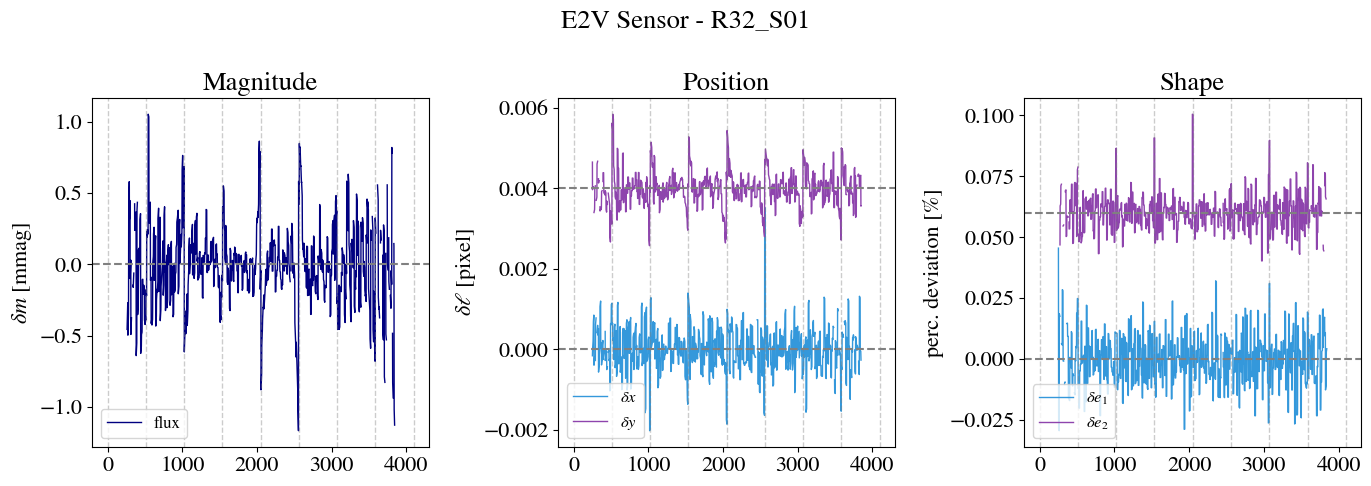

In [379]:
make_plot_figure2(figure2, 3, yline=1500, width=500, highPassFilter=True)

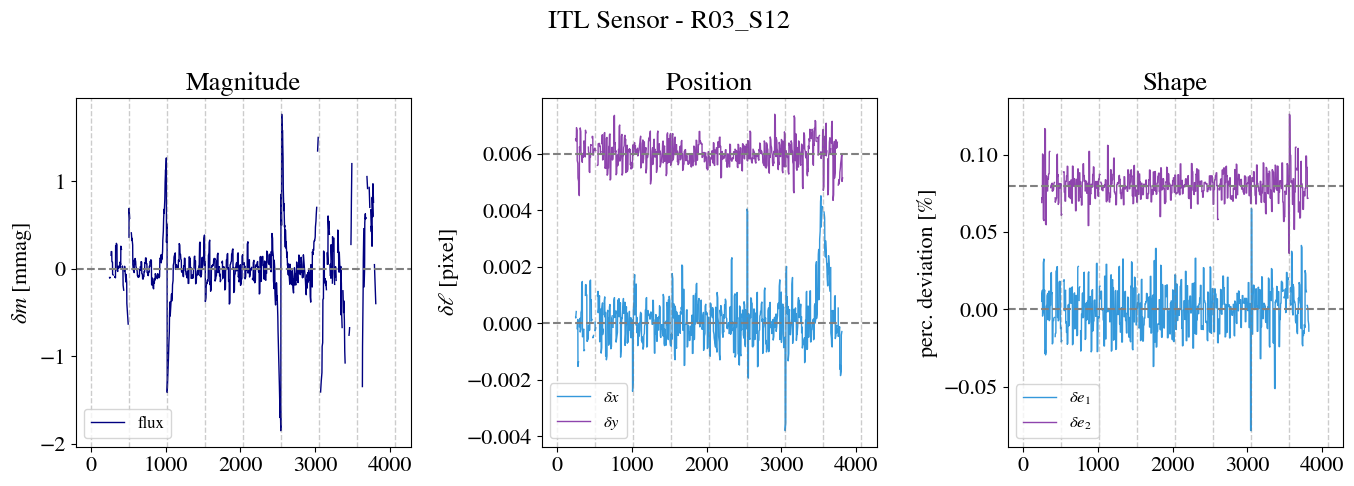

In [380]:
make_plot_figure2(figure2, 0, yline=1500, width=250, highPassFilter=True)

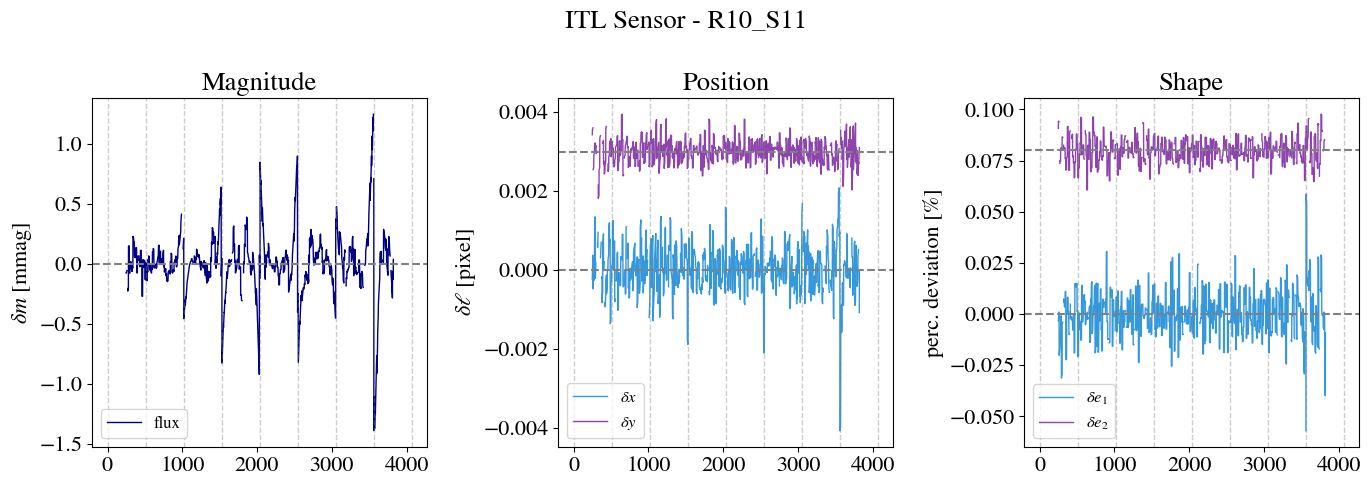

In [381]:
make_plot_figure2(figure2, 1, yline=1500, width=500, highPassFilter=True)

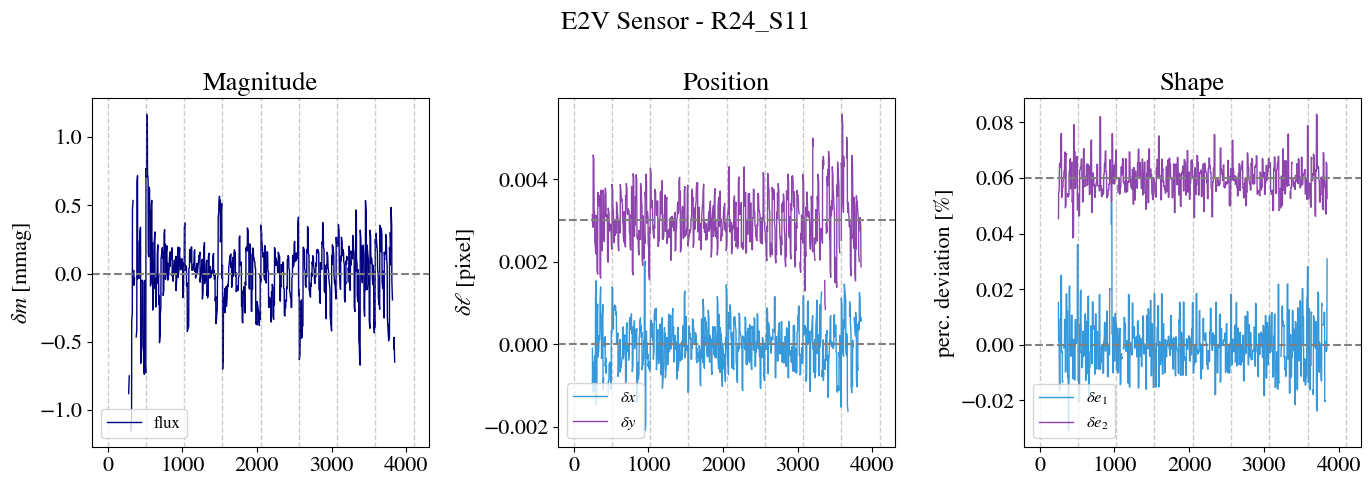

In [382]:
make_plot_figure2(figure2, 2, yline=1500, width=500, highPassFilter=True)

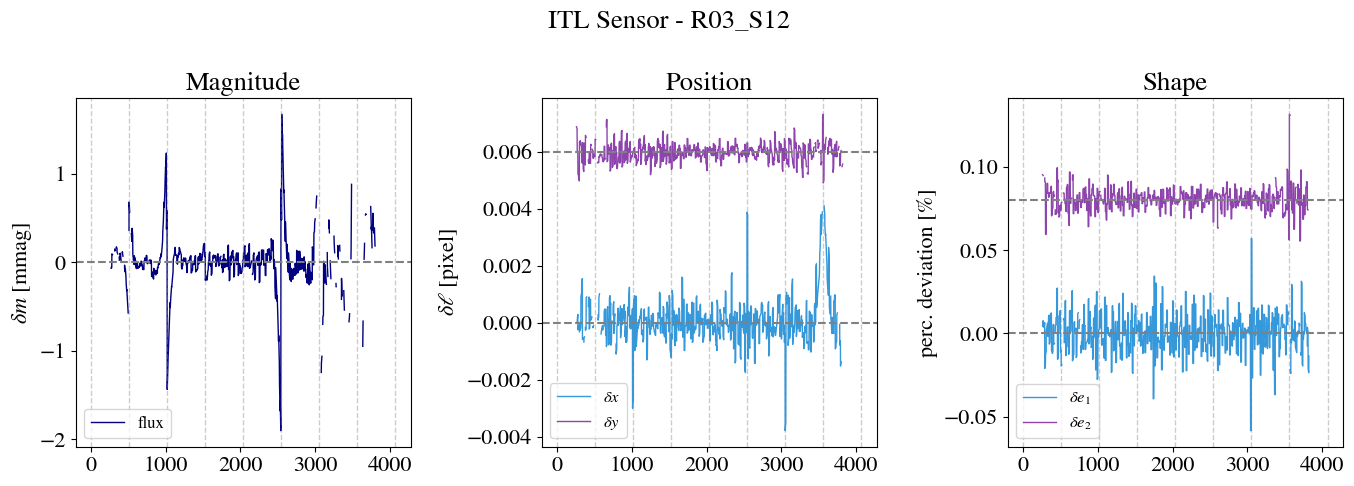

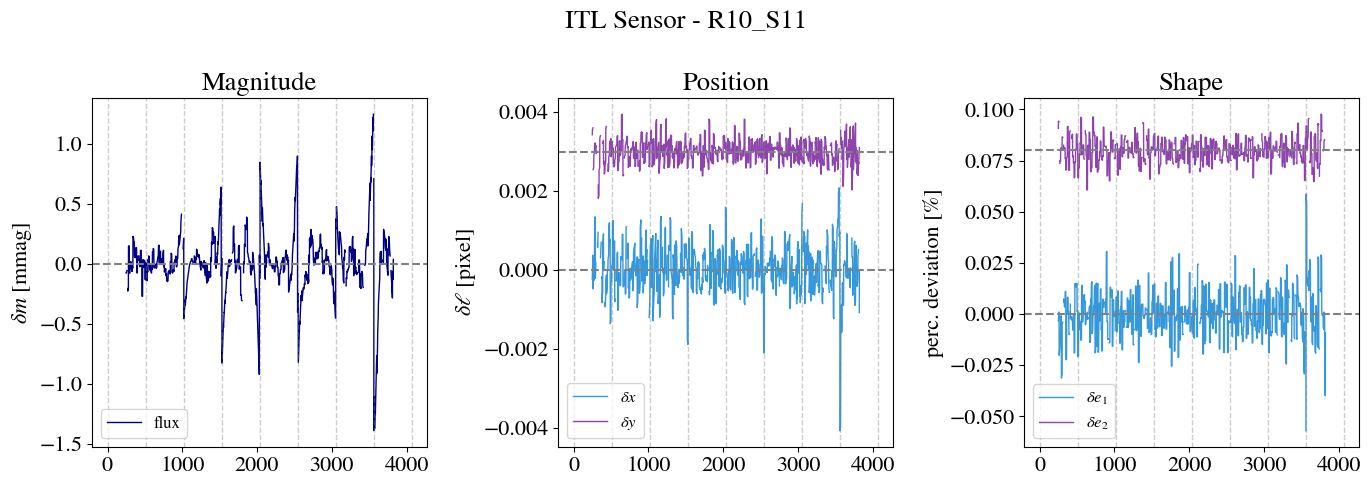

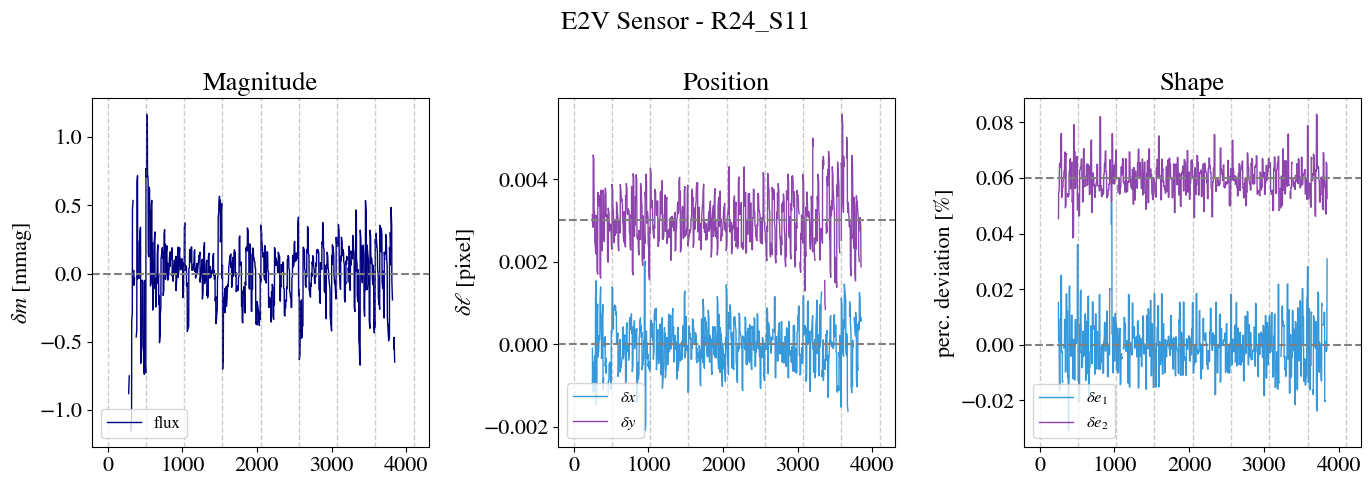

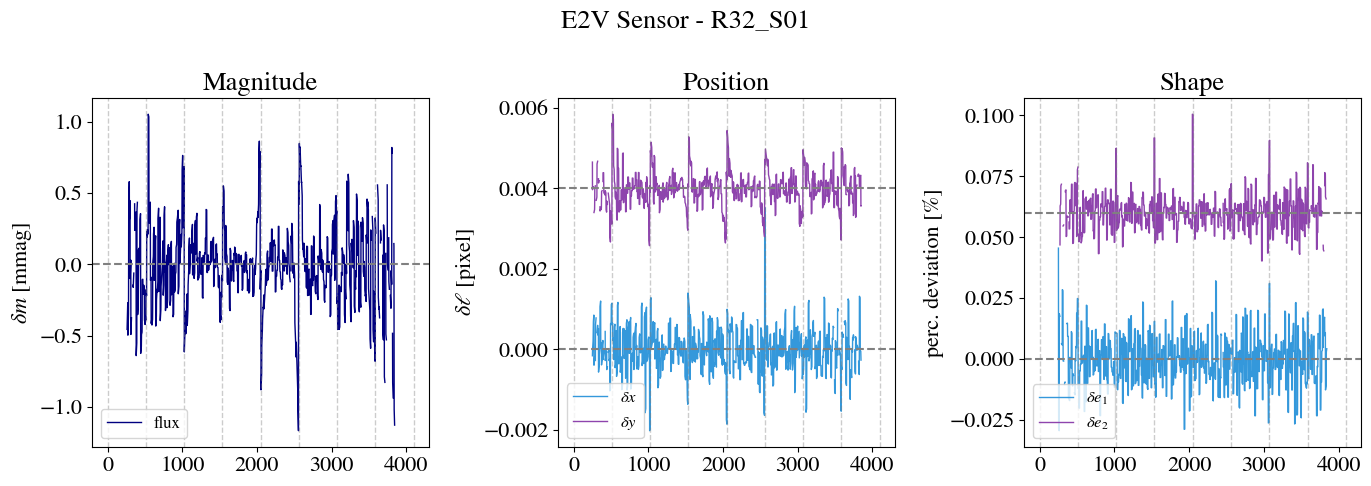

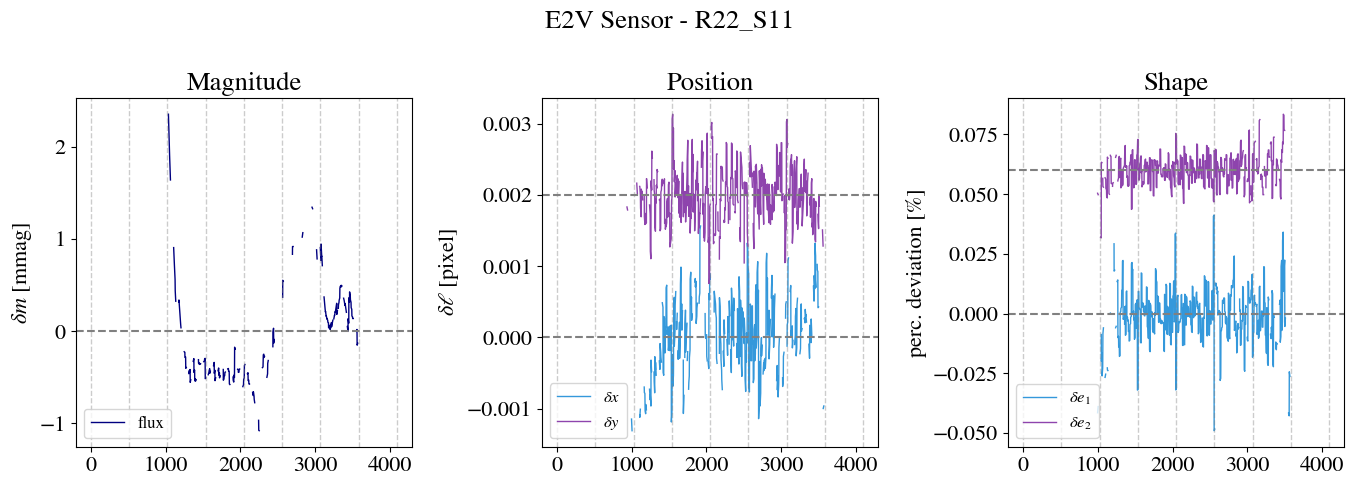

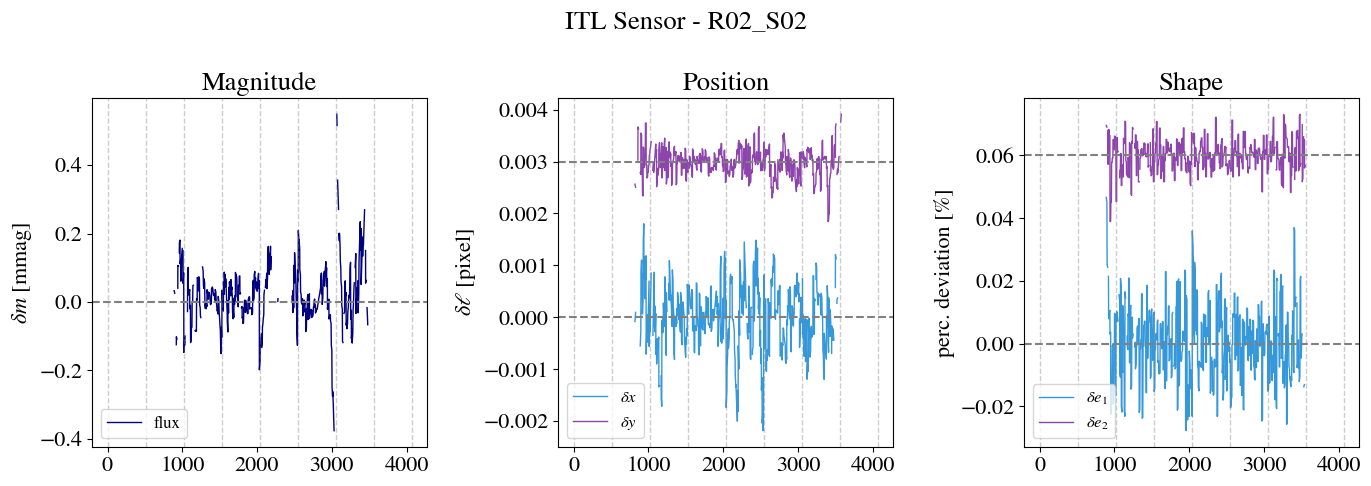

In [383]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

## plot square
with PdfPages('./figures/Figure2.pdf') as pdf:
    for ix in range(len(figure2['flux'])):
        make_plot_figure2(figure2, ix, yline=1500, width=500, highPassFilter=True)
        pdf.savefig()

In [325]:
keys2 = {
        'flux':['mag','Magnitude','$\delta m$ [mmag]','flux', 1000.],
        'psf-size':['abs','PSF-Size','perc. deviation [\%]','$\delta T$',100.],
        'pos-x':['x','Position','$\delta \ell$ [pixel]','$\delta x$',1.],
        'pos-y':['y','Position','$\delta \ell$ [pixel]','$\delta y$',1.],
        'shape-x':['x','Shape','perc. deviation [%]','$\delta e_1$',100.],
        'shape-y':['y','Shape','perc. deviation [%]','$\delta e_2$',100.],
       }

from bokeh.palettes import BrBG, PiYG, RdGy, RdYlGn, YlGnBu
# colorKeys = {
#         'flux': BrBG[9][0],
#         'psf-size': BrBG[9][0],
#         'pos-x': BrBG[9][0],
#         'pos-y': BrBG[9][7],
#         'shape-x': BrBG[9][7],
#         'shape-y': RdGy[9][8],
#        }

# colors = ['#003561', '#a2d6f9', '#f58b00']
# colors = [YlGnBu[9][1],YlGnBu[9][4], YlGnBu[9][6]]
colors = ['#3498DB','#8E44AD','#000080','k']
# colors = ['#E74C3C','#8E44AD','#3498DB','#16A085','#16A085','#000080','k']
colorKeys = {
        'flux': colors[2],
        'psf-size': colors[2],
        'pos-x': colors[0],
        'pos-y': colors[1],
        'shape-x': colors[0],
        'shape-y': colors[1],
       }


def component_map(shortcut):
    res = {
           'flux':'flux-ratio','psf-size':'psf-size',
           'pos-x':'astrometric-shift','pos-y':'astrometric-shift',
           'shape-x':'ellipticity','shape-y':'ellipticity',
          }
    return res[shortcut]

### Ridge Structure Detector

In [13]:
from scipy import ndimage as ndi
from skimage import feature


In [20]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image, sigma=0.1)
edges2 = feature.canny(image, sigma=3)

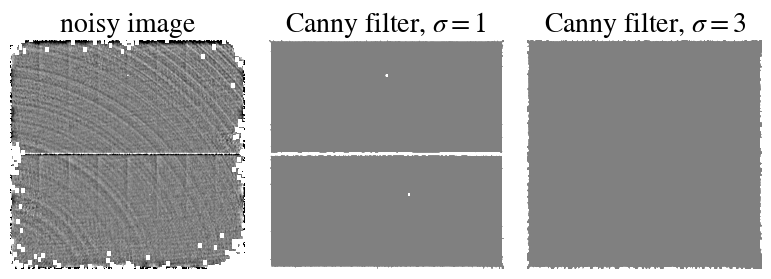

In [21]:
# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, vmin=-0.01, vmax=0.01, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, vmin=-0.01, vmax=0.01, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, vmin=-0.01, vmax=0.01, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

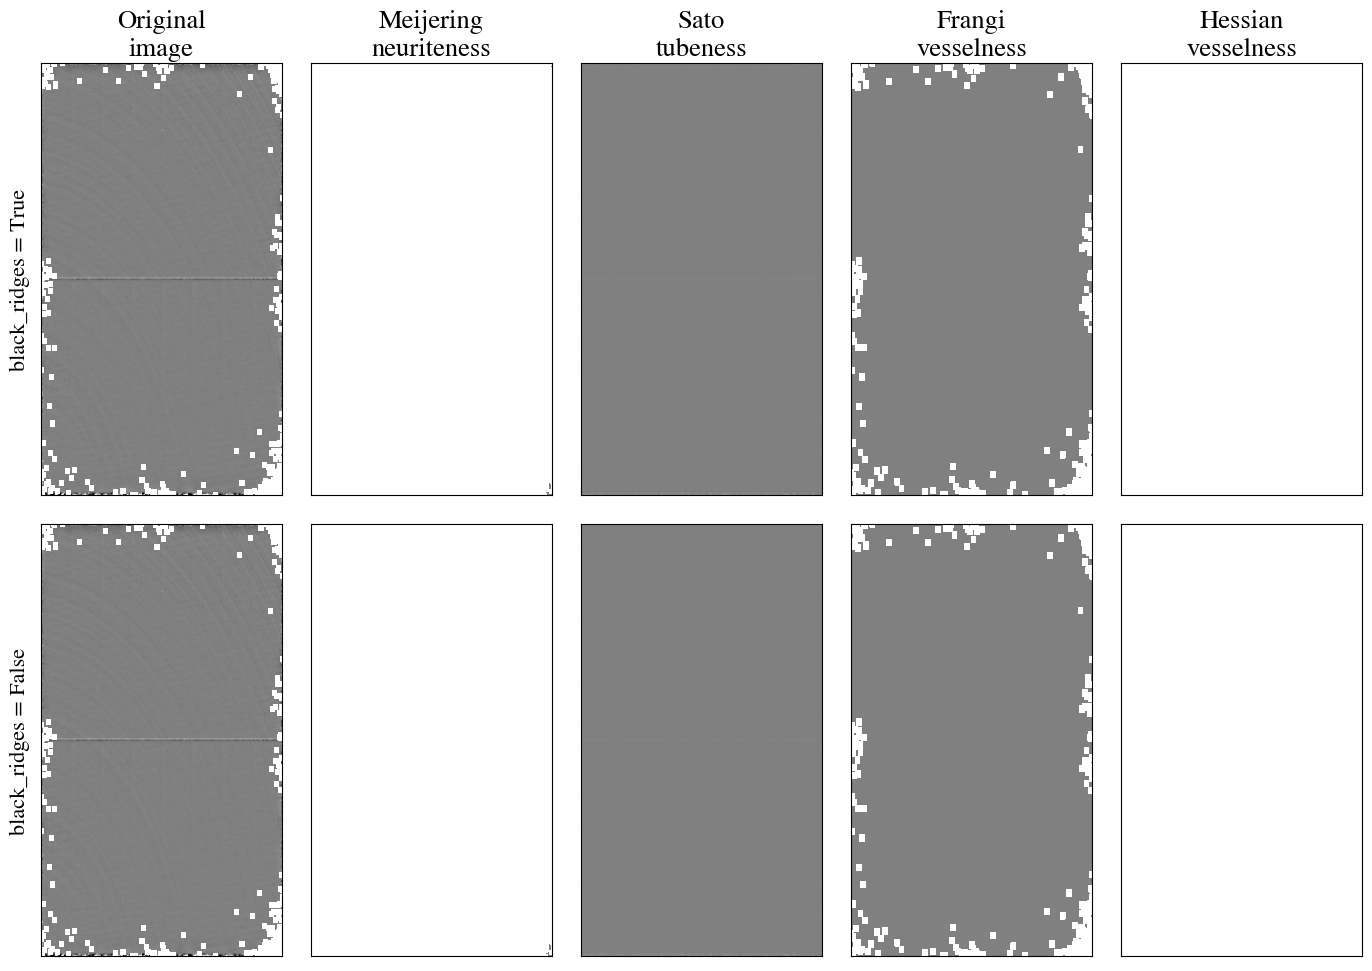

In [26]:
from skimage.filters import meijering, sato, frangi, hessian

def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


# image = color.rgb2gray(data.retina())[300:700, 700:900]
cmap = plt.cm.gray

kwargs = {'sigmas': [1], 'mode': 'reflect'}

fig, axes = plt.subplots(2, 5)
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
        kwargs['black_ridges'] = black_ridges
        result = func(image, **kwargs)
        axes[i, j].imshow(result, cmap=cmap, aspect='auto', vmin=-0.1, vmax=0.1)
        if i == 0:
            axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                  'Sato\ntubeness', 'Frangi\nvesselness',
                                  'Hessian\nvesselness'][j])
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

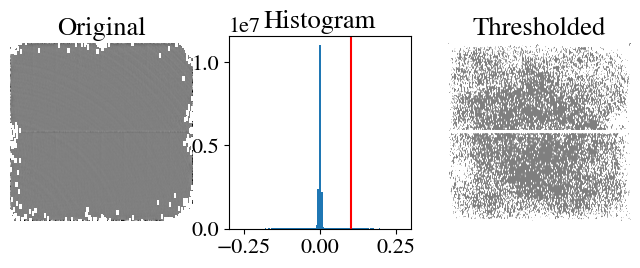

In [36]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(image[~np.isnan(image)])
binary = np.abs(image) > 0.005

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, vmin=-0.1, vmax=0.1, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')
ax[1].set_xlim(-0.3, 0.3)

ax[2].imshow(binary, vmin=-0.1, vmax=0.1, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [84]:
def imshow(image,axes,title='',show_colorbar=False,levels=[-0.015,0.015]):
    im0 = axes.imshow(image,origin='lower',vmin=levels[0],vmax=levels[1], cmap='viridis')
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.set_aspect('equal')
    axes.set_title(title)
    if show_colorbar: return im0

In [85]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

def make_plot_figure1(ix, highPassFilter=False):
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    #axes = axes.flatten()
    
    variables = ['flux','pos-x','shape-y',
                 'psf-size','pos-y','shape-x']
    count=0
    for i in range(2):
        for j in range(3):
            variable = variables[count]
            rings = figure2[variable]
            ring = rings[ix]
            if not highPassFilter:
                img = ring.img.copy()
            else:
                img = ring.diff.copy()
            
            #if variable=='flux':
                #img = np.log10(img/100) # mmag
                #img -= np.nanmedian(img)
                                
            l1, l2 = get_lim_img(img[25:-25,25:-25])
            im = imshow(img, axes[i,j],title=keys1[variable][1],
                        levels=[l1,l2],show_colorbar=True)
            
            if i>0:
                axes[i,j].set_xlabel('X position [pixels]', fontsize=15)
            if j==0:
                axes[i,j].set_ylabel('Y position [pixels]', fontsize=15)

    
            fig.colorbar(im, ax=axes[i,j], shrink=0.9).set_label(keys1[variable][2])    
            fig.suptitle(f'{ring.sensor.upper()} Sensor - {ring.sensorbay}')
            count+=1
            
    fig.tight_layout()
    return fig
        
def get_lim_img(x):
    xflat = x.flatten()
    lo, up = np.nanpercentile(xflat, [8, 92])
    return lo, up

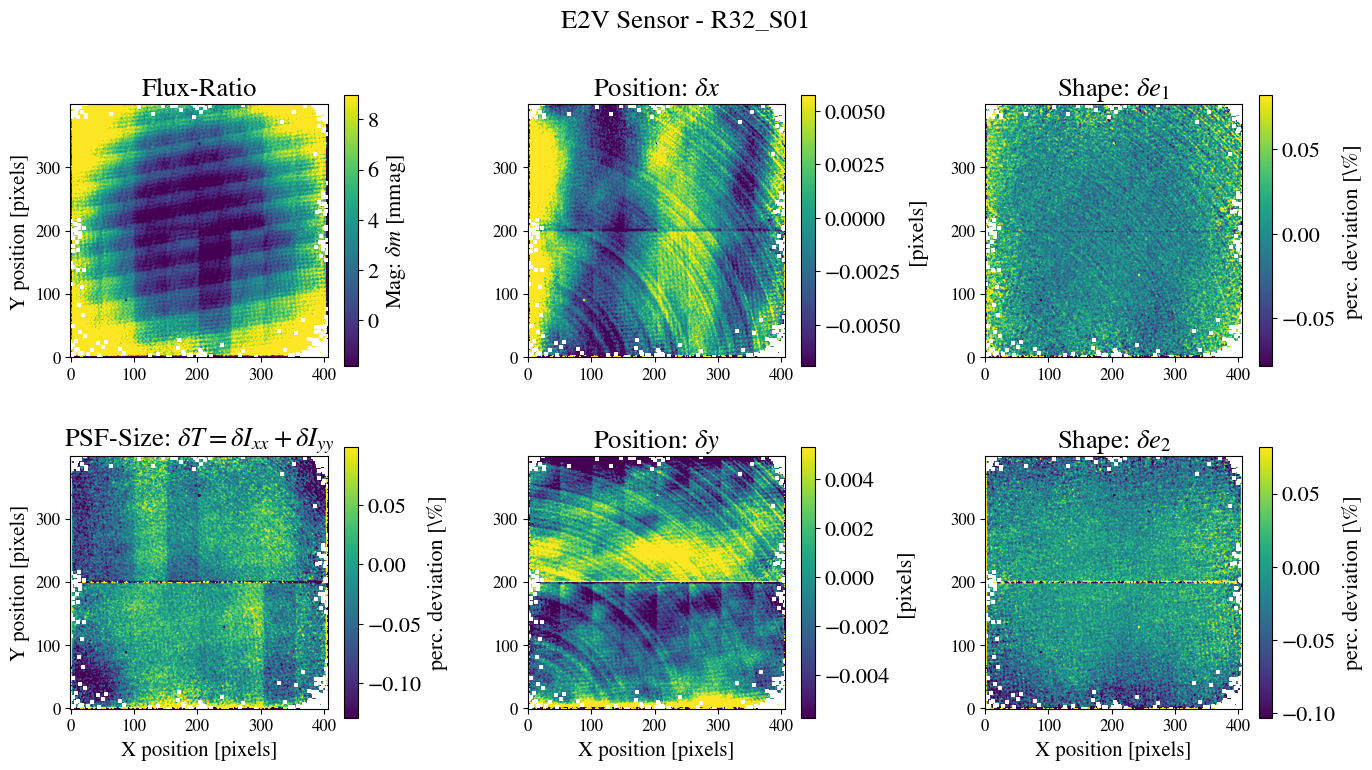

In [86]:
## plot square
with PdfPages('./figures/Figure2_image.pdf') as pdf:
    for ix in range(len(figure2['flux'])):
        make_plot_figure1(ix)
        pdf.savefig()
        
# saveFig(fig, './figures/Figure1')

I choose two figures as an example for each sensor.

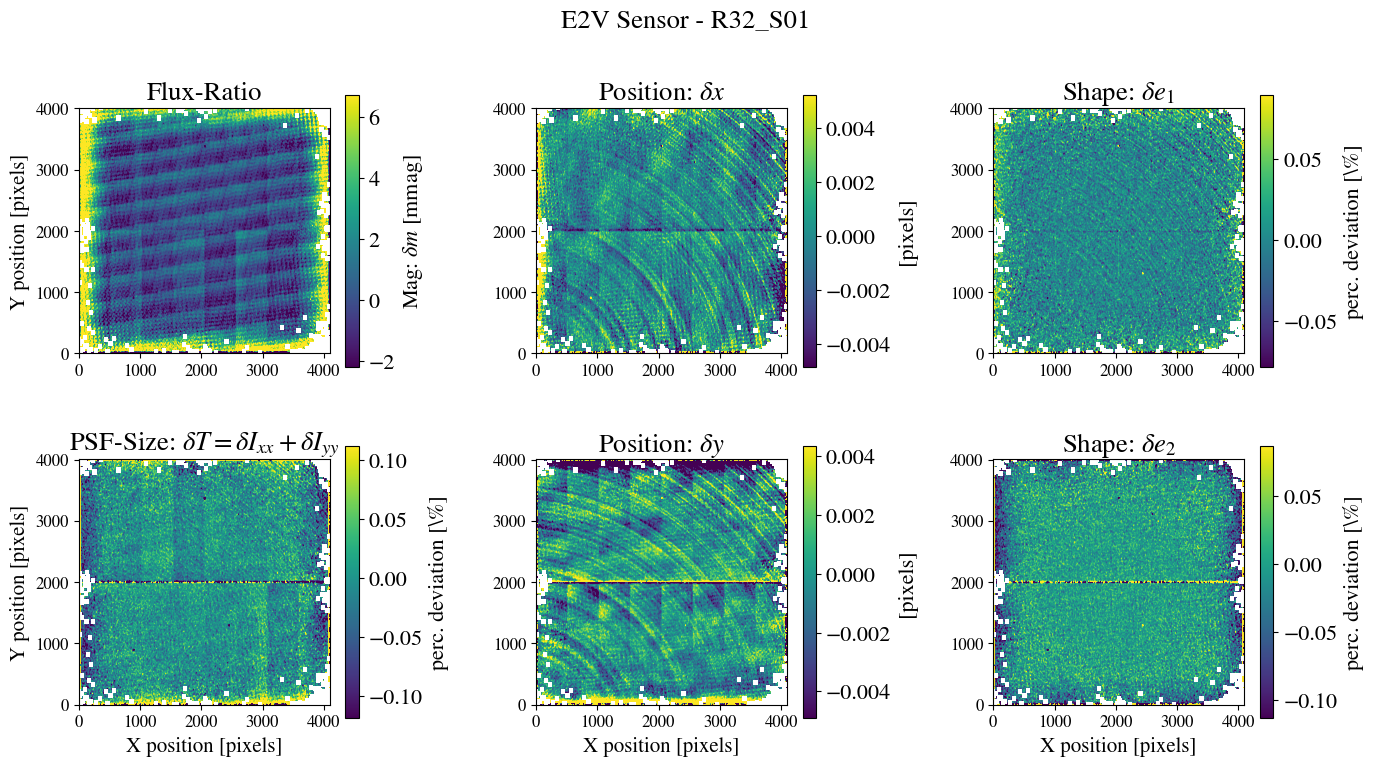

In [87]:
fig = make_plot_figure1(0, highPassFilter=True)
# saveFig(fig, './figures/bla.pdf')

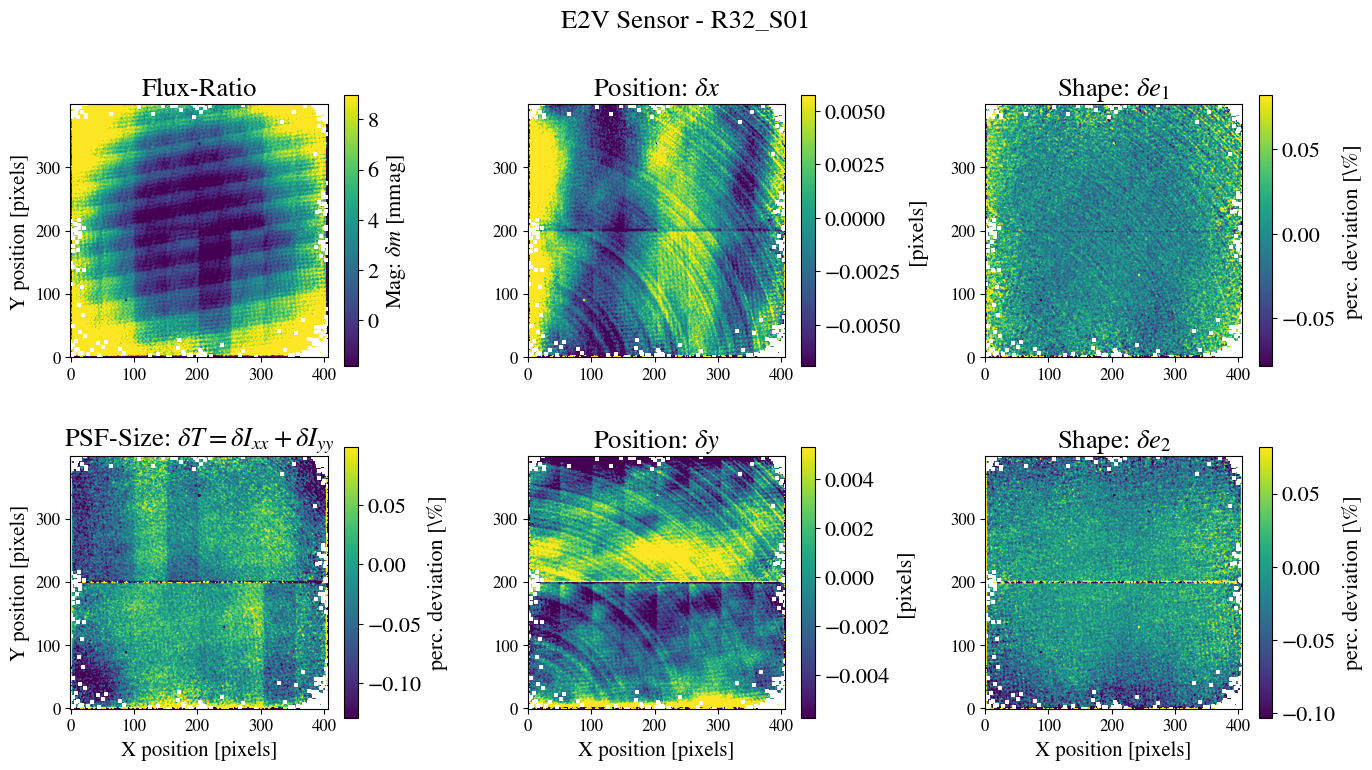

In [88]:
fig = make_plot_figure1(0, highPassFilter=False)